# Example in Ecuador: Working with OpenEO on Copernicus Data for Vegetation Indexes and Burn Scar analysis

Now that we have explored the basics of the Copernicus Data Space ecosystem and openEO, it’s time to apply these tools to a real-world case. In this exercise, we will use Sentinel-2 satellite data to investigate the effects of the severe drought and widespread fires that affected Ecuador in 2024.

We will begin by calculating NDVI and NDWI to assess vegetation health and moisture conditions before the fires. Later, we will create a burn scar index to map fire-affected areas and compare the pre- and post-event landscapes.

## 1.1 Installing the needed software  

To configure our software environment, we need to install several Python libraries which enable us to use openEO and provide functions for analyzing, processing, and visualizing satellite data.  

- **`openeo`**: To access and process Earth Observation data through the Copernicus Data Space Ecosystem using the openEO API.  
- **`numpy`**: For efficient numerical array operations (e.g., NDVI, NBR calculations).  
- **`matplotlib`**: For creating visualizations and plots of indices and difference maps.  
- **`rasterio`**: For reading, writing, and processing geospatial raster data in formats like GeoTIFF.  
- **`skimage.exposure`**: For image enhancement functions, e.g., contrast stretching when visualizing remote sensing data.  
- **`os`**: For interacting with the local file system (paths, renaming, directory management).  
- **`geopandas`**: For handling vector geospatial data (e.g., shapefiles, GeoJSON), useful when working with areas of interest (AOIs).  
- **`shapely`** (installed as a dependency of `geopandas`): For creating and manipulating geometric objects (points, polygons, etc.).  
- **`zipfile`**: For extracting or creating compressed `.zip` archives (useful when downloads arrive zipped).  
- **`glob`**: For finding file paths that match a given pattern (e.g., listing all `.tif` files in a folder).  

If any of these libraries are missing, they can be installed using:  

```bash
!pip install openeo numpy matplotlib rasterio geopandas shapely scikit-image


In [1]:
!pip install geopandas shapely
import openeo
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from skimage import exposure
import os
import geopandas as gpd
import glob


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.4/338.4 kB 7.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 16.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 16.3 MB/s eta 0:00:0000:0100:01


Set the bounds of your area of interest (already given):

In [2]:
areaOfInterest_bbox = {
    "west": -79.43459371,
    "south": -4.43222695,
    "east": -79.17572836,
    "north": -4.27133052
}

## 1.2 Sign in with your Account

To begin with, we need to connect to the Copernicus Data Space Ecosystem and authenticate ourselfes as a registered user. This enables us to get access to the data and services of the CDSE platform’s data and services. 

**Before you continue with the notebook, make sure that you have successfully registered as a user of the Copernicus Data Space Ecosystem at https://dataspace.copernicus.eu/**


In [4]:
# to authenticate, we use the following function provided by the openeo library:

connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

# after activating this cell, a link to CDSE's authentication widget will be displayed
# follow the link and confirm that this notebook can access the CDSE with your credentials
# after successfully completing this step a green checkmark followed by "Authorized successfully" should appear

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

## 1.3 Creating filters for retrieving the Sentinel 2 data

Next, we want to retrieve usable Sentinel-2 data for the area in Mazar Ecuador, where a severe fire event occurred from August 23 to August 28, 2025.

To focus our search on the community near Mazar called Loja, we use a bounding box as a **spatial filter**. We define the coordinates of the bounding box of our area of interest in such a way that the region around Loja is enclosed.  


In [5]:
# time period before the fire event

period_before = ["2024-07-01", "2024-08-22"] 


## 1.4 Loading Sentinel 2 data with a Datacube

To calculate the NDVI (Normalized Difference Vegetation Index), we load the bands B08 (NIR) and B04 (Red) of the Sentinel-2 data as a datacube. Datacubes are a key concept in OpenEO. If you want to learn more about datacubes, follow this link: https://openeo.org/documentation/1.0/datacubes.html. 


In [6]:
s2_data_before = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=areaOfInterest_bbox,
    temporal_extent=period_before,
    bands=["B03", "B04", "B08","B11", "B12"],
    max_cloud_cover=20
)


## 1.5 Calculating the NDVI
For this analysis, we will use the B04 (red) and B08 (near-infrared) bands of Sentinel-2, which are essential for NDVI calculations. This is a common index used to measure vegetation health. 
Luckily for us there already exists a function for that from the OpenEO API. OpenEO has many predefined functions like this, called processes, to perform calculations or mainpulate your data. These processes are also documented and can be found here: https://openeo.org/documentation/1.0/processes.html.

The NDVI formula is: NDVI = (NIR - Red) / (NIR + Red)

This index helps us to get a first impression of the impact of the fire on the vegetation. We will first create the NDVI image for the time before the fire and then compare it with the situation after the fire.

In [7]:
# --- NDVI ---
ndvi_before = (s2_data_before.band("B08") - s2_data_before.band("B04")) / \
             (s2_data_before.band("B08") + s2_data_before.band("B04"))
ndvi_mean_before = ndvi_before.reduce_dimension(dimension="t", reducer="mean")

## 1.6 Calculating the NBR  

In addition to NDVI, another important index for fire analysis is the **Normalized Burn Ratio (NBR)**.  
For this index, we use the B08 (near-infrared) and B12 (shortwave-infrared) bands of Sentinel-2.  

The NBR formula is:  
\[
NBR = \frac{(NIR - SWIR)}{(NIR + SWIR)}
\]

This index is specifically designed to highlight burned areas and the severity of fire damage.  
Healthy vegetation reflects strongly in the near-infrared (B08) and absorbs strongly in the shortwave infrared (B12), whereas burned areas show the opposite pattern.  

Similar to NDVI, we calculate the mean NBR value over the selected time period **before the fire**.  
Later, we will compare it with the NBR **after the fire** to compute the **differenced NBR (dNBR)**, which is widely used for burn severity assessment (following the UN-Spider recommended practice). 

In [8]:
# --- NBR ---
nbr_before = (s2_data_before.band("B08") - s2_data_before.band("B12")) / \
            (s2_data_before.band("B08") + s2_data_before.band("B12"))
nbr_mean_before = nbr_before.reduce_dimension(dimension="t", reducer="mean")

## 1.7 Creating and Starting a Batch Job
Since the processing of satellite data can take some time, we use OpenEO's batch job feature. A batch job processes the data asynchronously on the OpenEO backend, and once completed, we can download the results.

Here, we create and start a batch job to process the pre-fire NDVI data. Once the job is finished, the resulting NDVI image is downloaded and saved as a GeoTIFF file.

As the batch job processes, it’s important to monitor the job’s progress. This ensures that we know when the processing is complete and can download the results.

Once the job is finished (status = "finished"), the results can be downloaded directly, as shown in the previous step. If the job is still running or encounters an error, appropriate action can be 

We save the resulting NDVI image in GeoTIFF format. The GeoTIFF format allows us to store geospatial raster data with the correct geographic coordinates, ensuring that it can be easily loaded into GIS software for further analysis.taken.

In [9]:
output_dir = "results" 
sampleOutput_dir = "sampleOutput"

In [10]:
# --- Save results ---
indices = {
    "NDVI_Before_Fire.tif": ndvi_mean_before,
    "NBR_Before_Fire.tif": nbr_mean_before,
}

for filename, data in indices.items():
    result = data.save_result(format="GTiff")
    job = result.create_job()
    job.start_and_wait()
    
    if job.status() == "finished":
        job.get_results().download_files(output_dir)
        print(f"{filename.split('_')[0]} after fire downloaded successfully.")
        
        # Rename file
        downloaded_files = os.listdir(output_dir)
        for dl_file in downloaded_files:
            if dl_file == "openEO.tif":
                file_path = os.path.join(output_dir, dl_file)
                print(f"Renaming {dl_file} to {filename}")
                os.rename(file_path, os.path.join(output_dir, filename))
    else:
        print(f"Error in downloading {filename}")


0:00:00 Job 'j-25083115231546dd97e0d53574fd34b7': send 'start'
0:00:13 Job 'j-25083115231546dd97e0d53574fd34b7': created (progress 0%)
0:00:21 Job 'j-25083115231546dd97e0d53574fd34b7': created (progress 0%)
0:00:27 Job 'j-25083115231546dd97e0d53574fd34b7': created (progress 0%)
0:00:35 Job 'j-25083115231546dd97e0d53574fd34b7': created (progress 0%)
0:00:45 Job 'j-25083115231546dd97e0d53574fd34b7': created (progress 0%)
0:00:57 Job 'j-25083115231546dd97e0d53574fd34b7': queued (progress 0%)
0:01:13 Job 'j-25083115231546dd97e0d53574fd34b7': queued (progress 0%)
0:01:32 Job 'j-25083115231546dd97e0d53574fd34b7': queued (progress 0%)
0:01:57 Job 'j-25083115231546dd97e0d53574fd34b7': running (progress N/A)
0:02:27 Job 'j-25083115231546dd97e0d53574fd34b7': running (progress N/A)
0:03:04 Job 'j-25083115231546dd97e0d53574fd34b7': running (progress N/A)
0:03:51 Job 'j-25083115231546dd97e0d53574fd34b7': running (progress N/A)
0:04:49 Job 'j-25083115231546dd97e0d53574fd34b7': finished (progress 100

## 1.8 Show resulting .tif file
After downloading and renaming the GeoTIFF file, we can visualize the pre-fire NDVI image. By using rasterio and matplotlib, we can load and display the NDVI data with a suitable color map to interpret vegetation health. This visualization helps us to understand the state of the vegetation before the fire and serves as a baseline for later comparison with post-fire data.

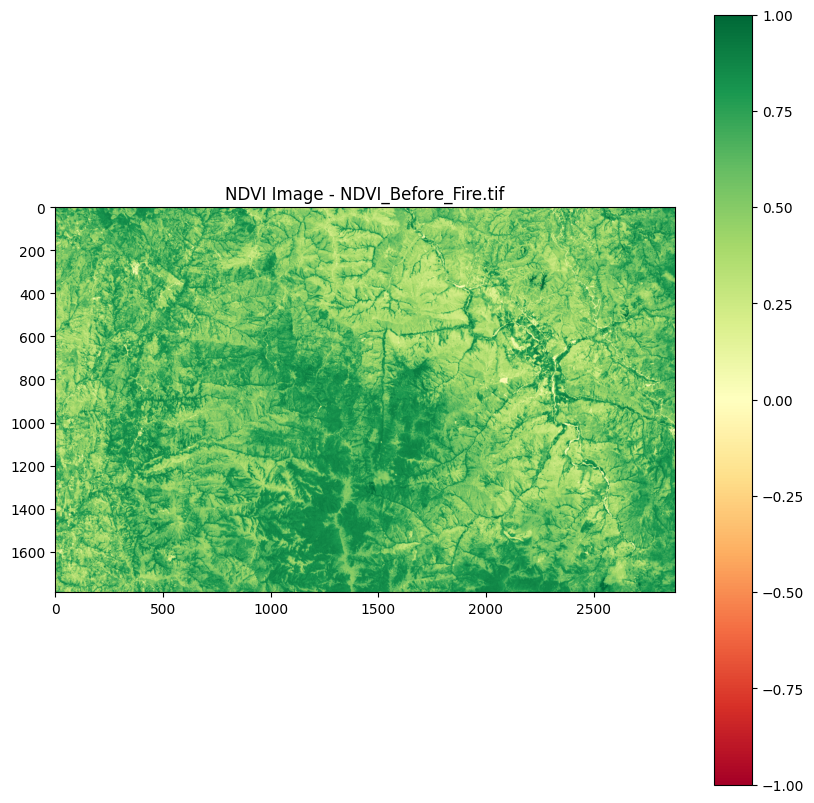

In [11]:
def plot_ndvi(filename, output_dir):
    file_path = os.path.join(output_dir, filename)
    
    if os.path.exists(file_path):
        with rasterio.open(file_path) as src:
            ndvi_data = src.read(1)
            ndvi_data = np.clip(ndvi_data, -1, 1)
            
            plt.figure(figsize=(10, 10))
            plt.title(f'NDVI Image - {filename}')
            plt.imshow(ndvi_data, cmap='RdYlGn', vmin=-1, vmax=1)
            plt.colorbar()
            plt.show()
    else:
        print(f"File {filename} not found!")

plot_ndvi("NDVI_Before_Fire.tif", output_dir)

## 2.1 Your Turn  

Now that we have processed the pre-fire situation, it’s time to repeat the workflow for the **post-fire period**.  
In this step, you will load Sentinel-2 data for a time window **after the fire** (e.g. between 27.08.2024 and 01.10.2024).  

We then calculate both the **NDVI** (Normalized Difference Vegetation Index) and the **NBR** (Normalized Burn Ratio) from the post-fire data.  

- **NDVI** helps us understand how vegetation health changed.  
- **NBR** is specifically useful to highlight burned areas.  

Finally, both indices are saved as GeoTIFF files so we can later compute the differences (NDVI difference and dNBR) to assess the fire’s impact on vegetation and burn severity.  

The code block below combines these steps:  

- Loading Sentinel-2 data with the required bands (B03, B04, B08, B12).  
- Computing post-fire NDVI and NBR.  
- Reducing them over time (to average values).  
- Saving the results into separate `.tif` files for further analysis.  
 fire.

In [12]:
import os

period_after = ["2024-08-27", "2024-10-01"]   # Please insert a time period here.

# Load Sentinel-2 data (include all needed bands)
s2_data_after = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=areaOfInterest_bbox,
    temporal_extent=period_after,
    bands=["B03", "B04", "B08", "B12"],   # Green, Red, NIR, SWIR
    max_cloud_cover=20
)

# --- NDVI ---
ndvi_after = (s2_data_after.band("B08") - s2_data_after.band("B04")) / \
             (s2_data_after.band("B08") + s2_data_after.band("B04"))
ndvi_mean_after = ndvi_after.reduce_dimension(dimension="t", reducer="mean")

# --- NBR ---
nbr_after = (s2_data_after.band("B08") - s2_data_after.band("B12")) / \
            (s2_data_after.band("B08") + s2_data_after.band("B12"))
nbr_mean_after = nbr_after.reduce_dimension(dimension="t", reducer="mean")

# --- Save results ---
indices = {
    "NDVI_After_Fire.tif": ndvi_mean_after,
    "NBR_After_Fire.tif": nbr_mean_after,
}

for filename, data in indices.items():
    result = data.save_result(format="GTiff")
    job = result.create_job()
    job.start_and_wait()
    
    if job.status() == "finished":
        job.get_results().download_files(output_dir)
        print(f"{filename.split('_')[0]} after fire downloaded successfully.")
        
        # Rename file
        downloaded_files = os.listdir(output_dir)
        for dl_file in downloaded_files:
            if dl_file == "openEO.tif":
                file_path = os.path.join(output_dir, dl_file)
                print(f"Renaming {dl_file} to {filename}")
                os.rename(file_path, os.path.join(output_dir, filename))
    else:
        print(f"Error in downloading {filename}")


0:00:00 Job 'j-25083115325448d1983cfd2686267f24': send 'start'
0:00:13 Job 'j-25083115325448d1983cfd2686267f24': created (progress 0%)
0:00:18 Job 'j-25083115325448d1983cfd2686267f24': running (progress N/A)
0:00:25 Job 'j-25083115325448d1983cfd2686267f24': running (progress N/A)
0:00:33 Job 'j-25083115325448d1983cfd2686267f24': running (progress N/A)
0:00:43 Job 'j-25083115325448d1983cfd2686267f24': running (progress N/A)
0:00:55 Job 'j-25083115325448d1983cfd2686267f24': running (progress N/A)
0:01:10 Job 'j-25083115325448d1983cfd2686267f24': running (progress N/A)
0:01:29 Job 'j-25083115325448d1983cfd2686267f24': running (progress N/A)
0:01:53 Job 'j-25083115325448d1983cfd2686267f24': running (progress N/A)
0:02:23 Job 'j-25083115325448d1983cfd2686267f24': finished (progress 100%)
NDVI after fire downloaded successfully.
Renaming openEO.tif to NDVI_After_Fire.tif
0:00:00 Job 'j-25083115352148bbb773e5ca13eac466': send 'start'
0:00:13 Job 'j-25083115352148bbb773e5ca13eac466': created (

## 2.2 Comparing the pre- and post-fire situation
Now you can display NDVI images side by side and compare the situation in Loja before and after the fire event. 


In [13]:
# definition of the NDVI-files that shall be plotted
files = [
    ("NDVI_Before_Fire.tif", output_dir, "Before Fire"),
    ("NDVI_After_Fire.tif", output_dir, "After Fire (your result)")]

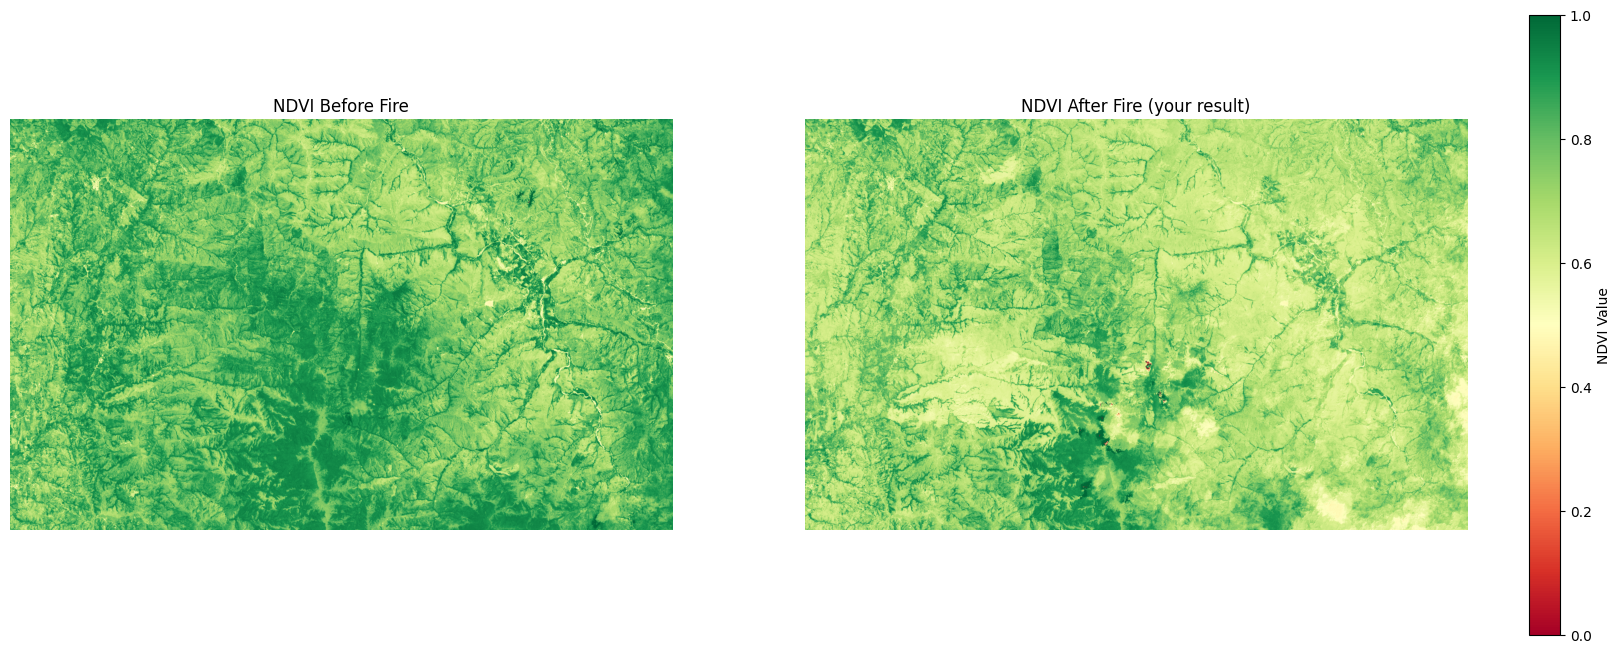

In [14]:

def plot_ndvi_images(files_and_dirs):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    for ax, (filename, directory, title) in zip(axes, files_and_dirs):
        file_path = os.path.join(directory, filename)
        
        if os.path.exists(file_path):
            with rasterio.open(file_path) as src:
                data = src.read(1)
                data = np.clip(data, -1, 1)

            ax.imshow(data, cmap='RdYlGn', vmin=-1, vmax=1)
            ax.set_title(f'NDVI {title}')
            ax.axis('off')
        else:
            print(f"File {filename} not found in directory {directory}.")

    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='RdYlGn'), ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('NDVI Value')

    plt.show()

plot_ndvi_images(files)

## 2.3 Comparing pre- and post-fire situation using the NDVI difference

After calculating the NDVI values for both pre-fire and post-fire data, we will visualize the NDVI difference to understand how the fire impacted vegetation in the Loja region.

The color scale:
- **Green**: Indicates areas where vegetation has even improved.
- **Red**: Indicates areas where vegetation health has decreased.

Below is an example plot showing the NDVI difference:
```python
plt.imshow(ndvi_difference, cmap="RdYlGn")
plt.colorbar(label="NDVI Difference")
plt.title("NDVI Difference (After - Before)")
plt.show()

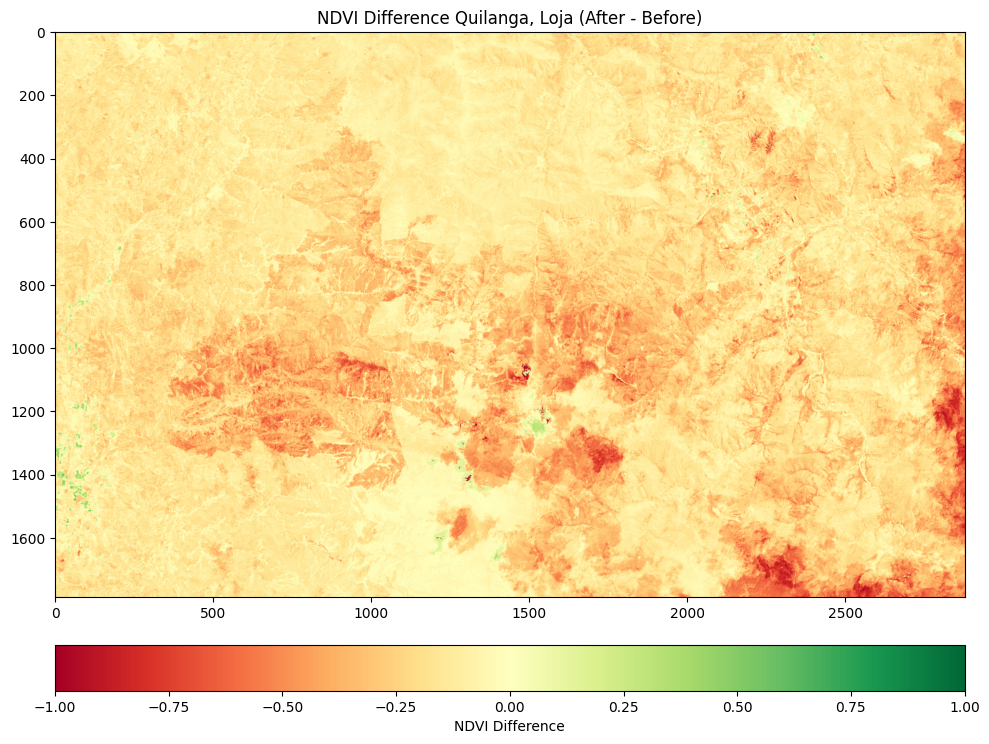

In [15]:
def calculate_ndvi_difference(before_path, after_path):
    with rasterio.open(before_path) as before_src:
        ndvi_before = before_src.read(1)
    
    with rasterio.open(after_path) as after_src:
        ndvi_after = after_src.read(1)

    ndvi_before = np.clip(ndvi_before, -1, 1)
    ndvi_after = np.clip(ndvi_after, -1, 1)
    
    ndvi_diff = ndvi_after - ndvi_before
    
    plot_ndvi_difference(ndvi_diff)

def plot_ndvi_difference(ndvi_diff):
    plt.figure(figsize=(10, 10))
    plt.title('NDVI Difference Quilanga, Loja (After - Before)')
    img = plt.imshow(ndvi_diff, cmap='RdYlGn', vmin=-1, vmax=1)
    cbar = plt.colorbar(img, orientation='horizontal', pad=0.05)
    cbar.set_label('NDVI Difference')
    plt.tight_layout()
    plt.show()

before_path = os.path.join(files[0][1], files[0][0])
after_path = os.path.join(files[1][1], files[1][0])

calculate_ndvi_difference(before_path, after_path)



### 2.4 Mapping burn severity using the differenced NBR (dNBR)  

To assess the burn scar and estimate fire severity, we calculate the **differenced Normalized Burn Ratio (dNBR)**.  
This index is obtained by subtracting the post-fire NBR from the pre-fire NBR:  

\[
dNBR = NBR_{before} - NBR_{after}
\]

- Healthy vegetation has high NBR values (due to strong NIR reflectance and weak SWIR reflectance).  
- After fire, NBR values decrease significantly (NIR drops, SWIR increases).  
- Thus, higher dNBR values indicate more severe burn damage.  

For visualization, we use a **color scale where brown to red areas mark stronger burn severity**, while green areas correspond to unchanged or recovering vegetation.  

The burn severity classification thresholds used here are based on the **UN-Spider recommended practice** for burn severity mapping.  
You can find the methodology and class definitions in detail at:  
[UN-Spider Burn Severity Recommended Practice](https://www.un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio)  

Below is an example plot showing the dNBR map:  

```python
plt.imshow(dnbr, cmap="RdYlGn_r", vmin=-1, vmax=1)
plt.colorbar(label="dNBR (NBR_before - NBR_after)")
plt.title("dNBR Burn Scar Severity Map")
plt.show()


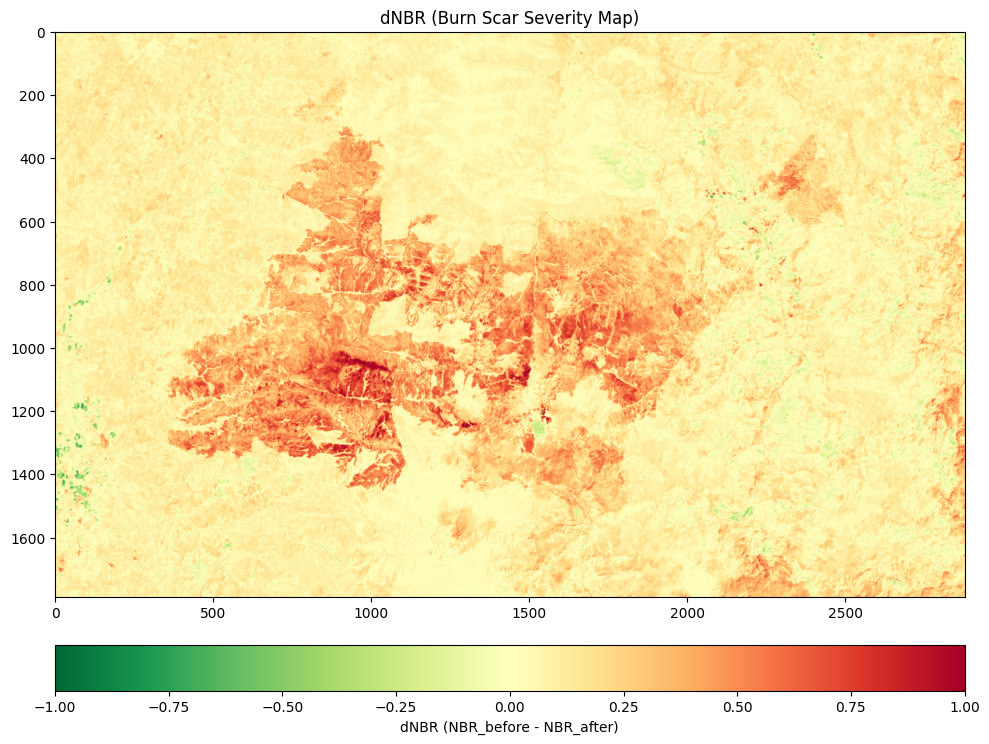

In [16]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

def calculate_dnbr(before_path, after_path):
    with rasterio.open(before_path) as before_src:
        nbr_before = before_src.read(1)
    
    with rasterio.open(after_path) as after_src:
        nbr_after = after_src.read(1)

    nbr_before = np.clip(nbr_before, -1, 1)
    nbr_after = np.clip(nbr_after, -1, 1)
    
    dnbr = nbr_before - nbr_after
    plot_dnbr(dnbr)
    return dnbr

def plot_dnbr(dnbr):
    plt.figure(figsize=(10, 10))
    plt.title('dNBR (Burn Scar Severity Map)')
    img = plt.imshow(dnbr, cmap='RdYlGn_r', vmin=-1, vmax=1)
    cbar = plt.colorbar(img, orientation='horizontal', pad=0.05)
    cbar.set_label('dNBR (NBR_before - NBR_after)')
    plt.tight_layout()
    plt.show()

# Paths to your saved NBR files
nbr_before_path = os.path.join(output_dir, "NBR_Before_Fire.tif")
nbr_after_path  = os.path.join(output_dir, "NBR_After_Fire.tif")

# Calculate & plot burn scar
dnbr = calculate_dnbr(nbr_before_path, nbr_after_path)


In [17]:
import matplotlib.colors as mcolors
# dNBR thresholds (as decimals, you can adjust scaling if your dNBR is normalized -1..1)
thresholds = [-0.5, -0.25, -0.1, 0.1, 0.27, 0.44, 0.66, 2.0]

# Corresponding colors from your SLD
colors = [
    "#ffffff",  # NA
    "#7a8737",  # Enhanced Regrowth, Low
    "#acbe4d",  # Enhanced Regrowth, High
    "#0ae042",  # Unburned
    "#fff70b",  # Low Severity
    "#ffaf38",  # Moderate-low Severity
    "#ff641b",  # Moderate-high Severity
    "#a41fd6",  # High Severity
]

# Labels for legend
labels = [
    "NA",
    "Enhanced Regrowth, Low",
    "Enhanced Regrowth, High",
    "Unburned",
    "Low Severity",
    "Moderate-low Severity",
    "Moderate-high Severity",
    "High Severity"
]

# Create a colormap and normalization
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(thresholds, cmap.N)


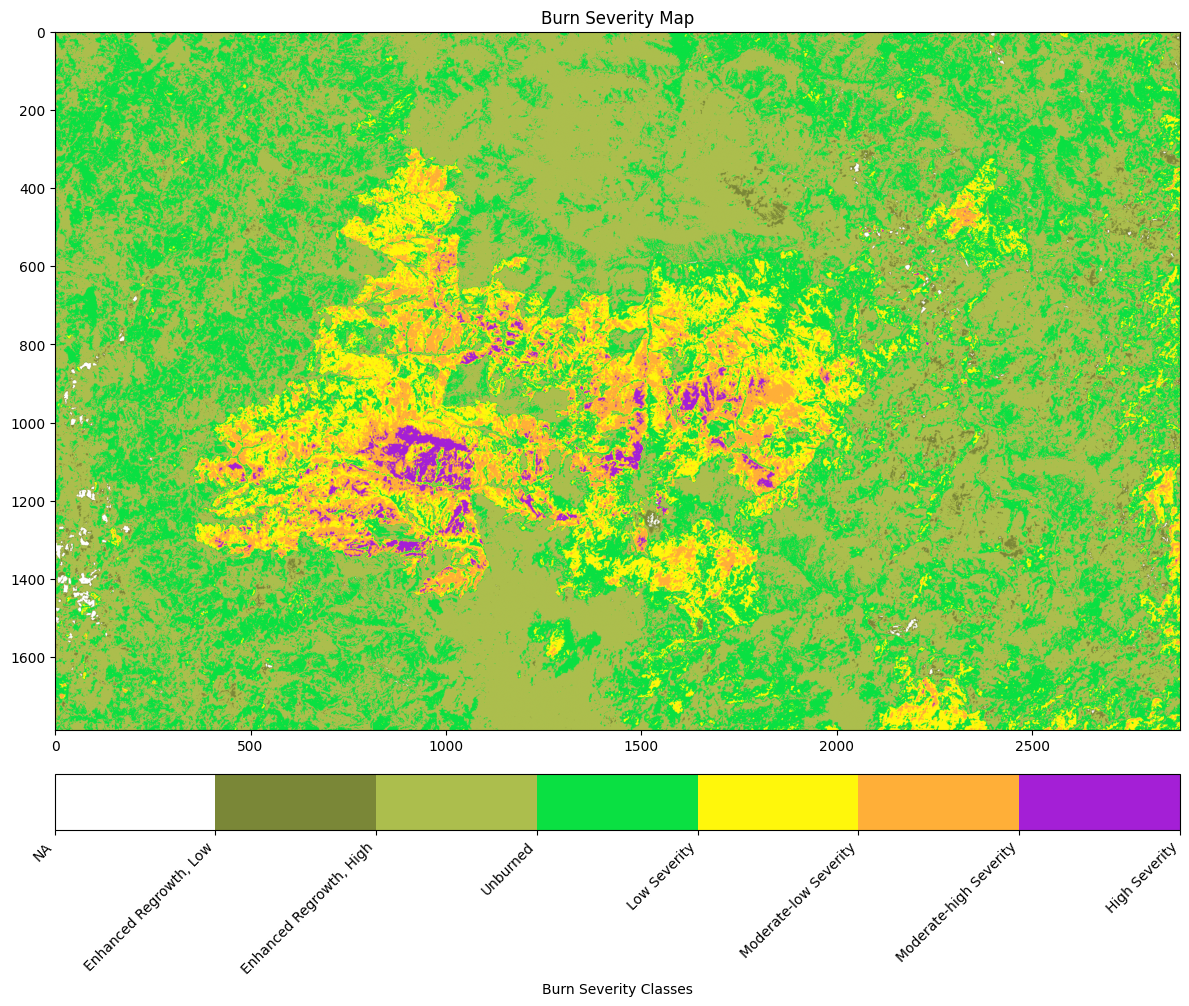

In [18]:
def plot_custom_burn_severity(dnbr):
    plt.figure(figsize=(12, 10))
    plt.title("Burn Severity Map")
    
    # Use the colormap and normalization
    img = plt.imshow(dnbr, cmap=cmap, norm=norm)
    
    # Create a colorbar with custom labels
    cbar = plt.colorbar(img, ticks=thresholds, orientation='horizontal', pad=0.05)
    cbar.ax.set_xticklabels(labels, rotation=45, ha='right')
    cbar.set_label("Burn Severity Classes")
    
    plt.tight_layout()
    plt.show()

# Plot
plot_custom_burn_severity(dnbr)



## Congratulations!!!

Beyond NDVI, you also explored an additional index **NBR/dNBR** for burn severity mapping.  
By applying the **UN-Spider recommended classification scheme**, you were able to transform continuous dNBR values into an intuitive burn severity map, clearly highlighting areas of low, moderate, and high fire impact.  

This workflow demonstrates how multiple spectral indices complement each other:  
- **NDVI** shows changes in overall vegetation healthe.  
- **NBR/dNBR** provides a standardized fire severity assessment.  

Together, they give a comprehensive picture of how wildfires affect ecosystems.  

The methods you practiced here can be easily adapted for other applications such as **flood monitoring, drought analysis, deforestation mapping, or agricultural crop monitoring**.  
With the combination of **Copernicus Sentinel data** and the **openEO API**, you now have a powerful, scalable framework for environmental monitoring and disaster impact assessment.  

---
✅ **Next steps:** Try experimenting with different time periods, study regions, or additional indices. You can even combine Sentinel-1 radar data for cloud-penetrating analysis. The possibilities for applying openEO and Python in environmental science are vast!  
tails.